# Contagion simulation showcase

Quick guide through the main functionalities of the NOVID-20 contagion simulation, used to asses the impact of different contagion spreading parameters on the importance of multi-step infection risk propagation.


## Introduction

NOVID-20 is a mobile app which tracks users' interactions, logs them locally and notifies users about their infection risks. Apart from the usual direct-contact-risk assessment which is based on previous direct contact with known infected users, it also propagates the risk through the network (in a distributed and anonymous way) to identify high-risk users who didn't have a direct **registered** contact with someone infected.

Simulations showcased here are composed of N separate contagion spread simulations running in parallel, with reported results averaged over them.

## Simulation parameters

In general, simulations are executed as follows:
1. Pick/generate a static network - this is an underlying network from which discrete time snapshots are generated.
2. Sample edges from the static network for each "day" of the simulation (in this sense, "day" is an abstract time interval), thus generating a discrete temporal network.
3. Set contagion spread parameters: initial infection probability, transmission probability, mean and std of the recovery time, etc.
4. Run the simulation.
5. Analyze stats through time, and particular snapshots which estimate the model performance.

#### Underlying static network

Main "parameter" of each simulation is the underlying **interaction network** on which these simulations are executed. To simulate interactions, we usually start with a static network and then sample it's edges each day to generate discrete temporal snapshots. During lock-downs, interaction networks become highly clustered and average path length increases (which is the exact purpose of a lock-down). As such generative models are rare, we analyzed different simple synthetic networks such as "ring of cliques" and others, and compared these to popular generative (but highly connected and less clustered) models such as Erdős–Rényi and Barabási–Albert. We also analyzed how different Kronecker networks behave in this setting. For more info about this model, refer to [1] and [2].


#### Temporal network

Once we have a static network, we assign a probability to each edge drawn from some predefined distribution called `frequency distribution`. Then, for each day of the simulation, we randomly sample edges based on these frequencies. For example, given a triangle (A, B, C), we might draw frequencies from a uniform 0..1 distribution, resulting in edge frequencies being f(A,B) = 0.5, f(A,C) = 0.2, f(C,B) = 0.9. This means that of 50% of days A will be in contact with B, on 20% of the days A will be in contact with C, and on 90% of the days C will be in contact with B. These frequencies are symmetrical (f(A,B) = f(B,A)) and anti-reflexive (f(A,A) = 0) since self-loops don't make sense in terms of contagion simulation (except if modelling recovery as a Poisson process which is not suitable in this case). It is important to note that these frequencies are in no way used as interaction weights - each interaction weights the same. Frequencies only control how often two nodes interact.

To model natural interaction process, especially during lock-down, we use a combination of two beta distributions ("bibeta") which, with some probability `p` draws from left-skewed beta distribution, otherwise from right-skewed beta distribution, thus modeling a highly bimodal distribution of contacts (family and close friends on one side and random contacts in stores or at workplace on the other). See below for a visualization of this distribution.

As a baseline, uniform distribution is used.

#### Contagion spread parameters

 - Initial infected nodes: optional binary vector defining which nodes are infected on day 0
 - Initial infected probability: if initial infection vector is not given, this probability is used to randomly infect nodes.
 - Infection probability: a.k.a. transmission probability - probability of infected node infecting a susceptible node during interaction
 - Mean and std of recovery time: normal distribution parameters modeling the recovery time (in "days") of infected node
 - Analysis day: day on which the benefits of multi-step contact tracing are calculated, which can later be displayed with through `model.performance_analysis`.
 
 
#### Other parameters
 - Share initial infection - if True, all simulations start with the same simulation. If initial infection vector is given, infection is always shared between simulations.
 - Number of days - number of days for which to run the simulation. Simulation will terminate early if none of the nodes in none of the simulations are infected anymore.
 

## References

[1] https://cs.stanford.edu/people/jure/pubs/kronecker-jmlr10.pdf  
[2] https://github.com/ibestvina/crowd-wisdom/blob/master/Bestvina%20-%20master%20thesis.pdf (Section 6, page 25)


## Notebook setup

In [1]:

%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
import matplotlib.style as style
style.use('seaborn')

from sim_model import SimModel
from multisim_model import MultisimModel
from netgens import *
import networkx as nx

# must come after other imports to override standard tqdm
from tqdm.notebook import tqdm

## Simple simulation

Simple simulation running on a small ER network.

In [2]:
INFECTED_P = 0.05
INFECTION_P = 0.01
RECOVERY_T = 14
RECOVERY_W = 5

G = nx.erdos_renyi_graph(1000, 0.05)
FREQ_DIST = 'uniform'

N_DAYS = 40
N_SIMS = 100
SHARE_INIT = True
ANALYSIS_DAY = 4

edge_gen = edge_gen_from_nx(G, N_DAYS, freq_dist=FREQ_DIST)
model = MultisimModel(len(G), edge_gen, INFECTED_P, INFECTION_P, 
                      RECOVERY_T, RECOVERY_W, N_DAYS, N_SIMS, 
                      share_init=SHARE_INIT, analysis_day=ANALYSIS_DAY, tqdm=tqdm)
model.run_sim()

No more infected nodes in any simulation, terminating on day 37.



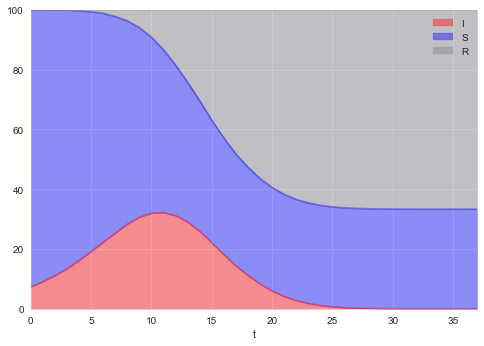

In [3]:
model.plot_stats()

Simulation stats through time look exactly as expected. ER network has randomly and independently distributed edges making the process look like the usual differential SIR analysis.

Direct contact performance
              Not notified  Notified
Not infected           183       655
Infected                15        88

Simulation performance (for non-direct contact nodes) if top 10% nodes are notified
              Not notified  Notified
Not infected           156        27
Infected                12         3


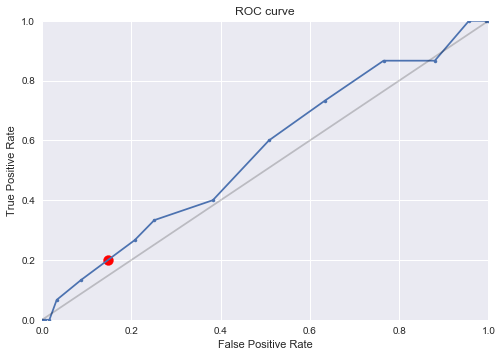

In [4]:
model.performance_analysis()

As expected, multi-step spread model doesn't perform well on ER and similar low-clustering networks with short average paths, because most of the network is already in the first neighborhood of someone infected. Second and other neigghborhoods mostly contain the whole network, making any models on those ranges look more-or-less like random guess.

However, it is a good example to showcase one feature of our models: manual score threshold setting. by default, all nodes in top 50% of the scores (excluding direct neighbors of initially infected nodes, and the infected nodes themselves) are notified (e.g. "predicted infected"). If we change this threshold, we can move along the ROC curve and analyze different confusion matrices. For example, setting the threshold to top 40%:

Direct contact performance
              Not notified  Notified
Not infected           183       655
Infected                15        88

Simulation performance (for non-direct contact nodes) if top 40% nodes are notified
              Not notified  Notified
Not infected            90        93
Infected                 6         9


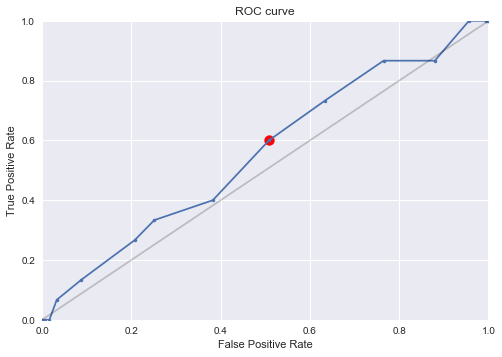

In [5]:
model.performance_analysis(notify_top_p=0.4)

For comparison, we can look at how different edge frequency distributions change the results. Using `bibeta` instead of `uniform`, we get better results as network is less connected.

First, let's visualize what the distribution looks like:

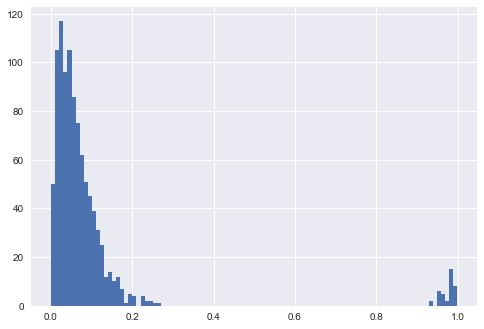

In [6]:
visualize_freq_dist('bibeta')

As explained in the introduction, most of the edges are highly infrequent (in the <10% range), and some are highly frequent (>90%).

In [16]:
INFECTED_P = 0.05
INFECTION_P = 0.01
RECOVERY_T = 14
RECOVERY_W = 5

G = nx.erdos_renyi_graph(1000, 0.05)
FREQ_DIST = 'bibeta'    # <- changed parameter

N_DAYS = 40
N_SIMS = 100
SHARE_INIT = True
ANALYSIS_DAY = 4

edge_gen = edge_gen_from_nx(G, N_DAYS, freq_dist=FREQ_DIST)
model = MultisimModel(len(G), edge_gen, INFECTED_P, INFECTION_P, 
                      RECOVERY_T, RECOVERY_W, N_DAYS, N_SIMS, 
                      share_init=SHARE_INIT, analysis_day=ANALYSIS_DAY, tqdm=tqdm)
model.run_sim()

No more infected nodes in any simulation, terminating on day 34.



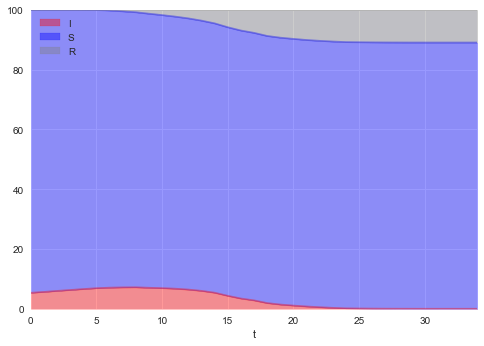

In [17]:
model.plot_stats()

Much fewer nodes are infected this time, as network is less connected. However, results are still not promising, and network is not clustered/compartmenalized in any way:

Direct contact performance
              Not notified  Notified
Not infected           692       245
Infected                 3         9

Simulation performance (for non-direct contact nodes) if top 35% nodes are notified
              Not notified  Notified
Not infected           427       265
Infected                 0         3


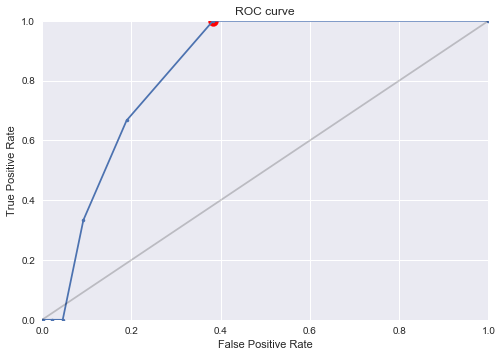

In [18]:
model.performance_analysis(0.35)

If confused by a seemingly great ROC curve, I suggest reading this: https://classeval.wordpress.com/simulation-analysis/roc-and-precision-recall-with-imbalanced-datasets/

##  Ring of cliques

Simple simulation based on the "ring of cliques" network. Ring of cliques is a network generated from K N-sized cliques (complete graphs) which are then connected into a ring (see [1] for an illustration).

This model, although higly unnatural, shows how the model behaves when the network is extremely compartmentalized.


[1] https://i.stack.imgur.com/6PW74.jpg

In [10]:
INFECTED_P = 0.05
INFECTION_P = 0.7    # Increasing the transmission probability because network is much less connected
RECOVERY_T = 14
RECOVERY_W = 5

G = nx.ring_of_cliques(1000, 5)   # 1000 cliques, each with 5 nodes
FREQ_DIST = 'bibeta'

N_DAYS = 40
N_SIMS = 100
SHARE_INIT = True
ANALYSIS_DAY = 4

edge_gen = edge_gen_from_nx(G, N_DAYS, freq_dist=FREQ_DIST)
model = MultisimModel(len(G), edge_gen, INFECTED_P, INFECTION_P, 
                      RECOVERY_T, RECOVERY_W, N_DAYS, N_SIMS, 
                      share_init=SHARE_INIT, analysis_day=ANALYSIS_DAY, tqdm=tqdm)
model.run_sim()

No more infected nodes in any simulation, terminating on day 36.



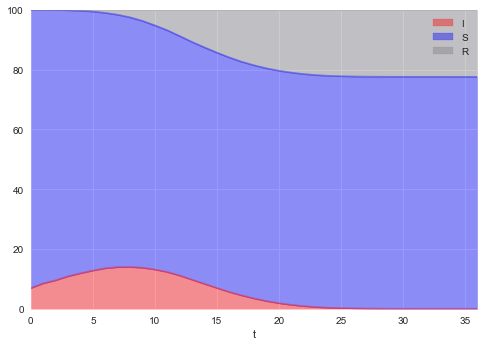

In [11]:
model.plot_stats()

Direct contact performance
              Not notified  Notified
Not infected          4393        16
Infected               241        94

Simulation performance (for non-direct contact nodes) if top 8% nodes are notified
              Not notified  Notified
Not infected          4260       133
Infected                 3       238


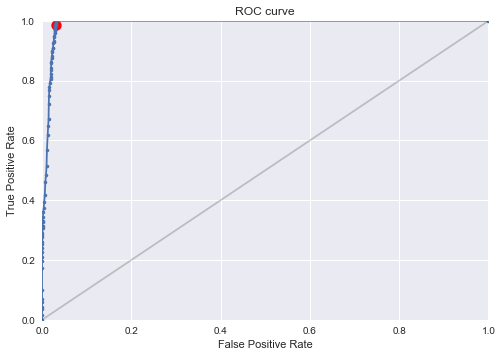

In [12]:
model.performance_analysis(0.08)

This is a strong evidence of the benefits of multi-step risk propagation in compartmenalized networks. As visible in the stats above, when top 8% of users (only considering those who haven't reported an infection and haven't been in close contact with the infected) are notified, ~250 of them really are infected, with only 120 getting false alerts. In comparison, direct-contact notifications only notified 110 infected people, although the false positive numbers are much lower (20 users).

##  Barabási–Albert

Similarly to ER, BA networks aren't clustered nor compartmenalized enough to model real work interactions. However, as this is an extremely popular model, we're analyzing it for completeness.

For detailed explanation of the model, see: https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model

In [13]:
INFECTED_P = 0.05
INFECTION_P = 0.2
RECOVERY_T = 14
RECOVERY_W = 5

G = nx.barabasi_albert_graph(10_000, 10)
FREQ_DIST = 'bibeta'

N_DAYS = 40
N_SIMS = 100
SHARE_INIT = True
ANALYSIS_DAY = 5

edge_gen = edge_gen_from_nx(G, N_DAYS, freq_dist=FREQ_DIST)
model = MultisimModel(len(G), edge_gen, INFECTED_P, INFECTION_P, 
                      RECOVERY_T, RECOVERY_W, N_DAYS, N_SIMS, 
                      share_init=SHARE_INIT, analysis_day=ANALYSIS_DAY, tqdm=tqdm)
model.run_sim()

No more infected nodes in any simulation, terminating on day 37.



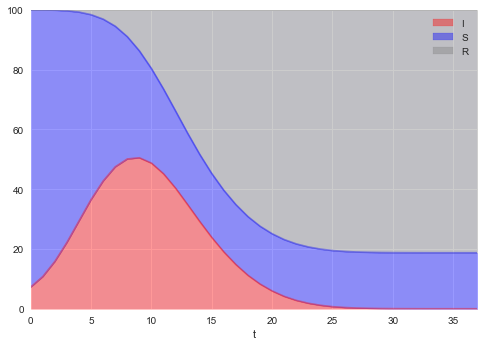

In [14]:
model.plot_stats()

Direct contact performance
              Not notified  Notified
Not infected          5834       294
Infected              2659       690

Simulation performance (for non-direct contact nodes) if top 30% nodes are notified
              Not notified  Notified
Not infected          4804      1030
Infected              1122      1537


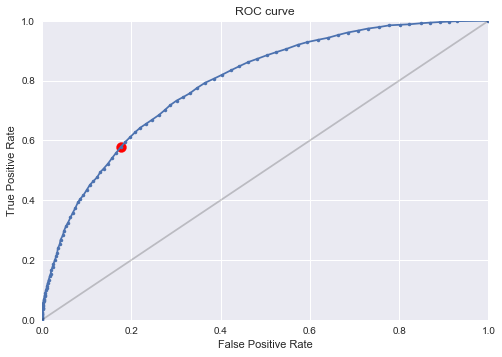

In [15]:
model.performance_analysis(0.3)

Although not a compartmenalized network, our appproach shows surprisingly good performance on BA networks.